# Correlating Returns

In [ ]:
!pip install python-dotenv
!pip install newsapi-python
!pip install -U textblob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 636 kB 5.2 MB/s 
  Attempting uninstall: textblob
    Found existing installation: textblob 0.15.3
    Uninstalling textblob-0.15.3:
      Successfully uninstalled textblob-0.15.3


In [ ]:
import os
import pandas as pd
from datetime import datetime, timedelta
from dotenv import load_dotenv
from newsapi.newsapi_client import NewsApiClient
from textblob import TextBlob
from pathlib import Path


## Load API Keys from Environment Variables

In [ ]:
# Load .env enviroment variables
load_dotenv()

# Set News API Key (to utlize other api keys simply change news_api to evan_news_api or christine_news_api)
newsapi = NewsApiClient(api_key=os.environ["news_api"])


In [ ]:
current_date = pd.Timestamp(datetime.now(), tz="America/New_York").isoformat()
past_date = pd.Timestamp(datetime.now()- timedelta(days=31), tz="America/New_York").isoformat()

## News API: Collecting articles

  

In [ ]:
# Use newsapi client to get most relevant 10 headlines per day in the past month
def get_headlines(keyword):
    all_headlines = []
    all_dates = []    
    date = datetime.strptime(current_date[:10], "%Y-%m-%d")
    end_date = datetime.strptime(past_date[:10], "%Y-%m-%d")
    print(f"Fetching news about '{keyword}'")
    print("*" * 30)
    while date > end_date:
        print(f"retrieving news from: {date}")
        articles = newsapi.get_everything(
            q=keyword,
            from_param=str(date)[:10],
            to=str(date)[:10],
            language="en",
            sort_by="relevancy",
            page_size= 10,
            page=1
        )
        headlines = []
        for i in range(0, len(articles["articles"])):
            headlines.append(articles["articles"][i]["title"])
        all_headlines.append(headlines)
        all_dates.append(date)
        date = date - timedelta(days=1)
    return all_headlines, all_dates

Note: Be aware that running the 3 requests below will only work once within a 24 hour period due to the request limits imposed by the API provider.

In [ ]:
# Get first topic
luna_headlines, dates = get_headlines("Terra Luna")

# Create Dataframe for news articles
luna_df = pd.DataFrame(
    {
        "luna_headlines": luna_headlines,
})
luna_df.index = pd.to_datetime(dates)

In [ ]:
# Get second topic
bit_headlines, dates = get_headlines("Bitcoin")

# Create Dataframe for news articles
bit_df = pd.DataFrame(
    {
        "bit_headlines": bit_headlines,
})
bit_df.index = pd.to_datetime(dates)

In [ ]:
# Get third topic
eth_headlines, dates = get_headlines("Ethereum")

# Create Dataframe for news articles
eth_df = pd.DataFrame(
    {
        "eth_headlines": eth_headlines,
})
eth_df.index = pd.to_datetime(dates)

In [ ]:
# Get fourth topic
bnb_headlines, dates = get_headlines("Binance USD")

# Create Dataframe for news articles
bnb_df = pd.DataFrame(
    {
        "bnb_headlines": bnb_headlines,
})
bnb_df.index = pd.to_datetime(dates)

In [ ]:
# Get fifth topic
sol_headlines, dates = get_headlines("Solana")

# Create Dataframe for news articles
sol_df = pd.DataFrame(
    {
        "sol_headlines": sol_headlines
})
sol_df.index = pd.to_datetime(dates)

In [ ]:
# Get sixith topic
ada_headlines, dates = get_headlines("Cardano")

# Create Dataframe for news articles
ada_df = pd.DataFrame(
    {
        "ada_headlines": ada_headlines,
})
ada_df.index = pd.to_datetime(dates)

## Getting Sentiment Polarity Scores as averages for articles in a given day. 

In [ ]:
# Create function that computes average compound sentiment of headlines for each day
def headline_sentiment_summarizer_avg(headlines):
    sentiment = []
    for day in headlines:
        day_score = []
        for h in day:
            if h == None:
                continue
            else:
                tb = TextBlob(h)
                day_score.append(tb.sentiment.polarity)
        sentiment.append(sum(day_score) / len(day_score))
    return sentiment

In [ ]:
# Get averages of each topics sentiment
luna_avg = headline_sentiment_summarizer_avg(luna_headlines)
bit_avg = headline_sentiment_summarizer_avg(bit_headlines)
eth_avg = headline_sentiment_summarizer_avg(eth_headlines)
bnb_avg = headline_sentiment_summarizer_avg(bnb_headlines)
sol_avg = headline_sentiment_summarizer_avg(sol_headlines)
ada_avg = headline_sentiment_summarizer_avg(ada_headlines)


In [ ]:
# Combine Sentiment Averages into DataFrame
topic_sentiments = pd.DataFrame(
    {
      "luna_avg": luna_avg,
      "bit_avg": bit_avg,
      "eth_avg": eth_avg,
      "bnb_avg": bnb_avg,
      "sol_avg": sol_avg,
      "ada_avg": ada_avg
    
    }
)

In [ ]:
# Set the index value of the sentiment averages DataFrame to be the series of dates.
topic_sentiments.index = pd.to_datetime(dates)

In [ ]:
topic_sentiments

,luna_avg,bit_avg,eth_avg,bnb_avg,sol_avg,ada_avg
2022-08-02,0.142045,-0.022500,0.020000,-0.016667,0.086190,0.044815
2022-08-01,0.041553,0.093333,-0.055000,0.062500,-0.056889,0.015000
2022-07-31,0.000000,0.082500,0.055303,0.250000,0.034444,0.171042
2022-07-30,-0.038817,0.033148,0.217720,0.053333,0.133451,-0.026852
2022-07-29,0.142222,-0.005177,0.092083,0.000000,0.025074,0.194318
2022-07-28,0.037273,0.024444,0.142500,0.145000,0.056250,0.135189
2022-07-27,-0.051250,0.005000,0.063081,0.365000,0.226667,-0.011932
2022-07-26,0.060000,0.042713,0.156667,0.128636,0.086458,0.138750
2022-07-25,0.042500,0.046667,-0.010000,0.000000,0.000455,0.026434
2022-07-24,-0.050000,0.114444,0.086263,-0.275000,-0.081420,0.058636


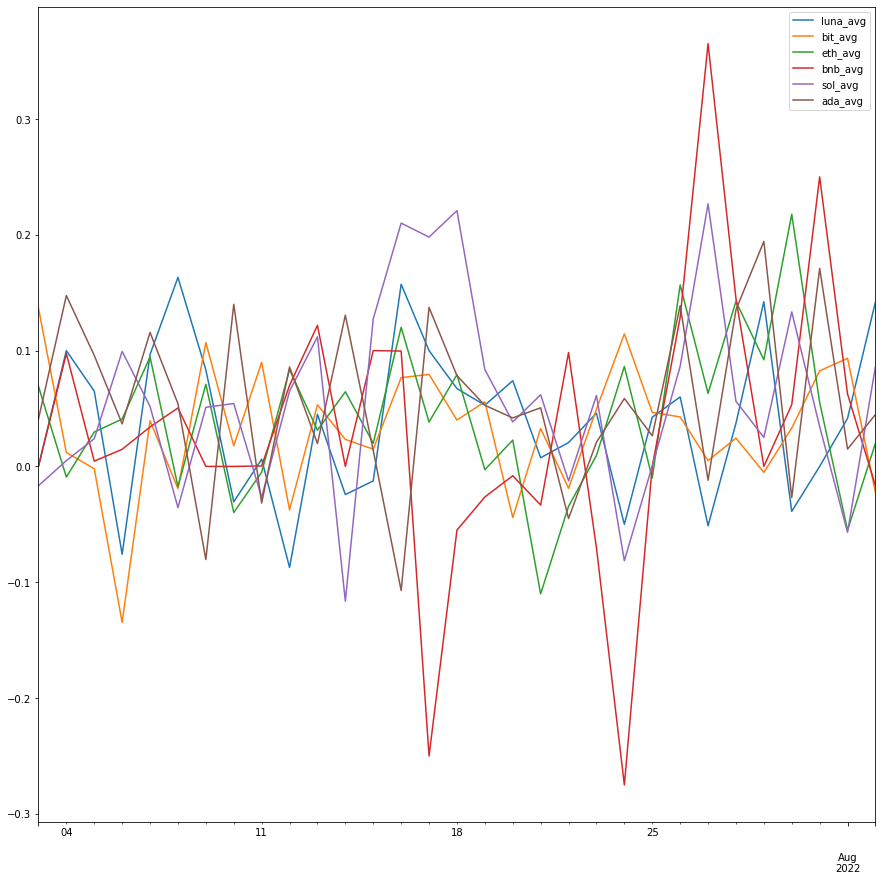

In [ ]:
topic_sentiments.plot(figsize=(15,15))

In [ ]:
# Correlate the headlines' sentiment to returns
topic_sentiments.corr().style.background_gradient()

,luna_avg,bit_avg,eth_avg,bnb_avg,sol_avg,ada_avg
luna_avg,1.000000,0.098933,-0.047550,-0.118052,0.091111,0.047270
bit_avg,0.098933,1.000000,0.089695,-0.203630,-0.120241,-0.144262
eth_avg,-0.047550,0.089695,1.000000,0.135032,0.302854,0.060493
bnb_avg,-0.118052,-0.203630,0.135032,1.000000,0.208066,-0.085685
sol_avg,0.091111,-0.120241,0.302854,0.208066,1.000000,-0.189711
ada_avg,0.047270,-0.144262,0.060493,-0.085685,-0.189711,1.000000


## Adding sentiment scores back to original dataframes

In [ ]:
final_luna_df = luna_df.join(topic_sentiments['luna_avg'])
final_bit_df = bit_df.join(topic_sentiments['bit_avg'])
final_eth_df = eth_df.join(topic_sentiments['eth_avg'])
final_bnb_df = bnb_df.join(topic_sentiments['bnb_avg'])
final_sol_df = sol_df.join(topic_sentiments['sol_avg'])
final_ada_df = ada_df.join(topic_sentiments['ada_avg'])

## Write articles to csv file 


In [ ]:
luna_path = Path('Lunanlp.csv')
luna_path.parent.mkdir(parents=True, exist_ok=True)
final_luna_df.to_csv(luna_path)

In [ ]:
bit_path = Path('Bitcoinnlp.csv')
bit_path.parent.mkdir(parents=True, exist_ok=True)
final_bit_df.to_csv(bit_path)

In [ ]:
eth_path = Path('Ethereumnlp.csv')
eth_path.parent.mkdir(parents=True, exist_ok=True)
final_eth_df.to_csv(eth_path)

In [ ]:
bnb_path = Path('Binancenlp.csv')
bnb_path.parent.mkdir(parents=True, exist_ok=True)
final_bnb_df.to_csv(bnb_path)

In [ ]:
sol_path = Path('Solananlp.csv')
sol_path.parent.mkdir(parents=True, exist_ok=True)
final_sol_df.to_csv(sol_path)

In [ ]:
ada_path = Path('Cardanonlp.csv')
ada_path.parent.mkdir(parents=True, exist_ok=True)
final_ada_df.to_csv(ada_path)